# Analysis: tropical cyclone statistics over test period 2010-2020

This colab presents a detailed analysis of the tropical cyclone statistics over period 2010-2020 from the reference ERA5 dataset, the original LENS2 simulations, and the GenFocal-downscaled simulations.

The colab takes as input the pre-computed tropical cyclone tracks over the North Atlantic basin, using the [TempestExtremes](https://climate.ucdavis.edu/tempestextremes.php) package and following the methods outlined in [Wan et al. (2025)](https://arxiv.org/abs/2412.08079).

## Install dependencies

In [ ]:
!pip install git+https://github.com/google-research/swirl-dynamics.git@main
!pip install cartopy

## Imports

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from etils import epath
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import tqdm.auto as tqdm
import warnings

filesys = epath.backend.tf_backend
sns.set_style("white")
plt.rcParams.update({'font.size': 12})
warnings.filterwarnings("ignore")

## Download and load pre-processed tropical cyclone tracks

We provide pre-processed cyclone track from the GenFocal outputs, detected by the [TempestExtremes](https://climate.ucdavis.edu/tempestextremes.php) library, in the North Atlantic Ocean (NAO) region (see section G.3.1 in [paper](https://arxiv.org/abs/2412.08079) for criteria). The results can be downladed (using [gsutil](https://cloud.google.com/storage/docs/gsutil_install)) from our Google Cloud Storage bucket.

In [ ]:
#@title Specify download directory
DOWNLOAD_TO_PATH = "tc_results/" # @param {"type":"string"}

In [ ]:
#@title Download data to local disk (~5min)
!mkdir {DOWNLOAD_TO_PATH}
!gsutil -m -q cp -R gs://genfocal/results/cyclones {DOWNLOAD_TO_PATH}

## Configuration and helper functions

In [ ]:
# Range of longitudes and latitudes to be plotted
LON_RANGE = [260, 350]
LAT_RANGE = [5, 45]

# Time period of analysis
ANALYSIS_PERIOD = [2010, 2020]
MONTHS = [8, 9, 10]

TIME_RESOLUTION = 6 # hours
# Parameters used for tropical cyclone detection and calibration
DELTA_P = 200 # Pa (default threshold)
DELTA_P_CAL = 120 # Pa (GenFocal threshold after calibration)
DELTA_DIST = 5.0 # Great circle distances
MERGE_DIST = 6.0 # Great circle distances
MAX_MOVE_RANGE = 8.0
MIN_HRS = 54 # Minimum temporal persistence of pressure minima (hours)
MAX_GAP_HRS = 24 # Maximum temporal gap
WIND_THRES = 10.0 # Minimum wind speed (m/s)
WIND_THRES_SLICES = 8

TRAJ_SMOOTHING = 3
NUM_CATEGORIES = 5  # Up to category 3 hurricanes
CATEGORY_ORDER = [
    "Tropical Depression",
    "Tropical Storm",
    "Category 1 Hurricane",
    "Category 2 Hurricane",
    "Category 3 Hurricane",
    "Category 4 Hurricane",
    "Category 5 Hurricane",
]

CATEGORY_LABELS = [
    "Tropical\n Depression",
    "Tropical\n Storm",
    "Category 1\n Hurricane",
    "Category 2\n Hurricane",
    "Category 3\n Hurricane",
    "Category 4\n Hurricane",
    "Category 5\n Hurricane",
]

# Categories included on plots
CATEGORY_ORDER = CATEGORY_ORDER[:NUM_CATEGORIES]
CATEGORY_LABELS = CATEGORY_LABELS[:NUM_CATEGORIES]

In [ ]:
#@title Track processing functions

def load_tracks(group):
  """Load TC track csv files."""
  exp = f"{DOWNLOAD_TO_PATH}/{group}/**.csv"
  files = filesys.glob(exp)
  files = sorted(
      files, key=lambda x: int(x.split("/")[-1].split("_")[-1][:-4])
  )  # sort by member idx

  dfs = []
  for f in tqdm.tqdm(files):
    df = pd.read_csv(f)
    df = df.iloc[:, 1:]
    dfs.append(df)

  return dfs

def filter_tracks(df, ah_wind_thres):
  """Filter tracks based on wind speed."""
  mask = df["ah_wind"] > ah_wind_thres
  return df[mask]


def compute_frequency(dfs, resolution=1.0):
  """Creates a histogram for TC occurrences."""
  lat_min, lat_max = LAT_RANGE
  lon_min, lon_max = LON_RANGE
  lat_bins = np.arange(lat_min, lat_max + resolution, resolution)
  lon_bins = np.arange(lon_min, lon_max + resolution, resolution)

  hist = []
  for df in dfs:
    hist_data, *_ = np.histogram2d(
        df['lon'].to_list(), df['lat'].to_list(),
        bins=[lon_bins, lat_bins],
        range=[[lon_min, lon_max], [lat_min, lat_max]]
    )
    hist.append(hist_data)
  hist_data = np.stack(hist, axis=0)

  return hist_data


def bin_winds(dfs, resolution=1.0):
  """Intensity embodied by the median pressure-derived wind speed."""
  lat_min, lat_max = LAT_RANGE
  lon_min, lon_max = LON_RANGE
  lat_bins = np.arange(lat_min, lat_max + resolution, resolution)
  lon_bins = np.arange(lon_min, lon_max + resolution, resolution)

  winds = np.empty((len(lon_bins) - 1, len(lat_bins) - 1), dtype=object)
  for i in range(len(lon_bins) - 1):
    for j in range(len(lat_bins) - 1):
      winds[i, j] = []

  for df in dfs:
    lon_indices = np.digitize(df['lon'].to_numpy(), lon_bins) - 1
    lat_indices = np.digitize(df['lat'].to_numpy(), lat_bins) - 1
    ah_wind = df['ah_wind'].to_numpy()

    for lon_i, lat_j, ah_w in zip(lon_indices, lat_indices, ah_wind):
      if lon_i < len(lon_bins) - 1 and lat_j < len(lat_bins) - 1:
        winds[lon_i, lat_j].append(ah_w)

  return winds

In [ ]:
#@title Plotting functions
def plot_map(data, ax, left_labels=True, bot_labels=True, **kwargs):
  """Creates a geospatial imshow plot."""
  im = ax.imshow(
      np.rot90(data),
      extent=[LON_RANGE[0] - 180, LON_RANGE[1] - 180, LAT_RANGE[0], LAT_RANGE[1]],
      transform=ccrs.PlateCarree(central_longitude=180), **kwargs
  )
  ax.set_aspect("equal")
  ax.set_xlim([LON_RANGE[0] - 180, LON_RANGE[1] - 180])
  ax.set_ylim([LAT_RANGE[0], LAT_RANGE[1]])
  ax.coastlines(resolution="50m", linewidth=0.3, color="black")
  ax.add_feature(cfeature.OCEAN, color="white")
  ax.add_feature(cfeature.LAND, color="lightgray")
  gl = ax.gridlines(
      draw_labels=True, linewidth=0.5, color='gray',
      alpha=0.5, linestyle='--',
  )
  gl.top_labels = False
  gl.right_labels = False
  gl.left_labels = left_labels
  gl.bottom_labels = bot_labels
  gl.xlabel_style = {'size': 12}
  gl.ylabel_style = {'size': 12}
  return im


def add_cbar(im, fig, spec, vpos=0.03, **kwargs):
  """Adds a colorbar to a plot."""
  cbar_ax = fig.add_axes(
      [
          spec.get_position(fig).x0 + 0.005,
          spec.get_position(fig).y0 + vpos,  # Move up slightly
          spec.get_position(fig).width * 0.13,
          spec.get_position(fig).height * 0.85  # Reduce height
      ],
  )
  cbar = fig.colorbar(im, cax=cbar_ax, orientation="vertical", **kwargs)
  cbar.ax.tick_params(axis="both", length=2, labelsize=12)

def moving_average(y, window_size):
  window = np.ones(window_size) / window_size
  return np.convolve(y, window, mode='valid')

def plot_tracks(ax, counts, lon_range, lat_range,
                smooth_window=6, annotate_count=True,
                count_font_size=10, tag=None,
                tag_font_size=14,
                fontweight='bold',
                fontname='Arial',
                **kwargs):
  for track_id in counts["track_id"].unique():
    track_rows = counts[counts["track_id"] == track_id]
    track_lon, track_lat = track_rows["lon"].to_numpy(), track_rows["lat"].to_numpy()
    if smooth_window:
      track_lon = moving_average(track_lon, smooth_window)
      track_lat = moving_average(track_lat, smooth_window)
    ax.plot(track_lon - 180, track_lat, **kwargs)

  ax.set_aspect("equal")
  ax.set_xlim([lon_range[0] - 180, lon_range[1] - 180])
  ax.set_ylim(lat_range)
  ax.coastlines(resolution="50m", linewidth=0.3, color="black")
  ax.add_feature(cfeature.OCEAN, color="white")
  ax.add_feature(cfeature.LAND, color="lightgray")

  if tag is not None:
    ax.annotate(
        tag,
        xy=(0.03, 0.95),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="white"),
        fontsize=tag_font_size,
        fontweight=fontweight,
        fontname=fontname,
    )
  if annotate_count:
    ax.annotate(
        f"Total count: {int(track_id + 1)}",
        xy=(0.5, 0.15),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="white"),
        fontsize=count_font_size,
    )

## Loading and examining TC tracks

In [ ]:
#@title Load pre-computed tracks (LENS2, ERA5, GenFocal)
lens2_tracks = load_tracks("cyclones/lens2_nao_tracks_aso2010s") # 100 realizations from LENS2
ref_tracks = load_tracks("cyclones/era5_reference_nao_tracks_aso2010s")[0] # Single historical realization
tracks = load_tracks("cyclones/genfocal_filtered_nao_tracks_aso2010s") # 800 realizations from GenFocal

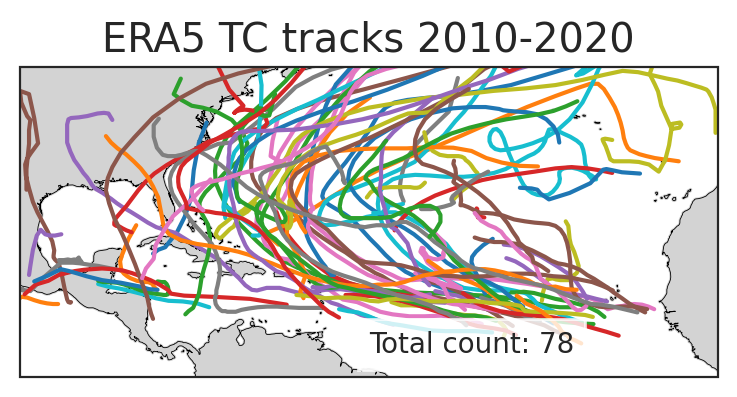

In [ ]:
#@title Plot reference ERA5 tracks over 2010-2020
fig, axes = plt.subplots(
    1, 1, figsize=(4.5, 3), dpi=200,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)
im = plot_tracks(
    axes, ref_tracks, LON_RANGE, LAT_RANGE, smooth_window=TRAJ_SMOOTHING
)
axes.set_title(f"ERA5 TC tracks {ANALYSIS_PERIOD[0]}-{ANALYSIS_PERIOD[1]}")
plt.show()

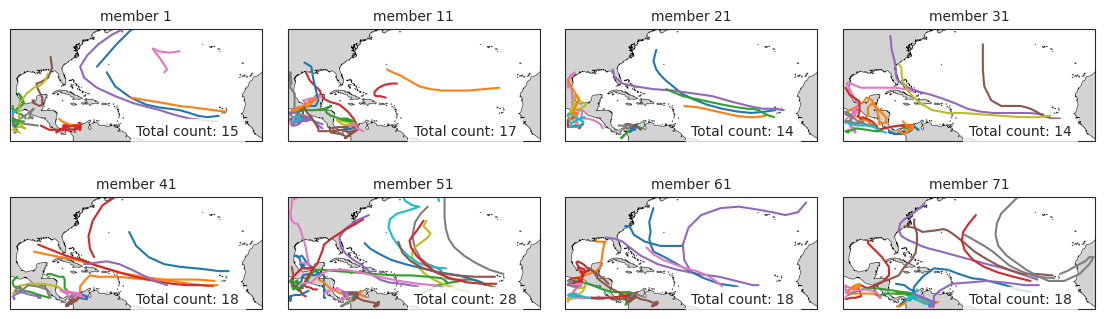

In [ ]:
#@title LENS2 tracks

plot_members = np.arange(8) * 10

fig, axes = plt.subplots(
    2, 4, figsize=(14, 4), dpi=100,
    gridspec_kw={'wspace': 0.1, 'hspace': 0.2},
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)

for i, m in enumerate(plot_members):
  r, c = i // 4, i % 4
  im = plot_tracks(
      axes[r, c], lens2_tracks[m],
      LON_RANGE, LAT_RANGE, smooth_window=TRAJ_SMOOTHING
  )
  axes[r, c].set_title(f"member {m+1}", fontsize=10)

plt.tight_layout()
plt.show()

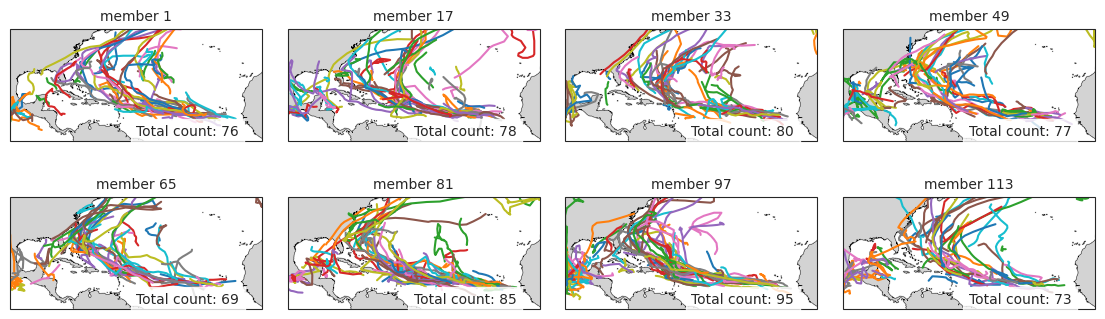

In [ ]:
#@title GenFocal downscaled tracks

plot_members = np.arange(8) * 16

fig, axes = plt.subplots(
    2, 4, figsize=(14, 4), dpi=100,
    gridspec_kw={'wspace': 0.1, 'hspace': 0.2},
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)

for i, m in enumerate(plot_members):
  r, c = i // 4, i % 4
  im = plot_tracks(
      axes[r, c], tracks[m],
      LON_RANGE, LAT_RANGE, smooth_window=TRAJ_SMOOTHING
  )
  axes[r, c].set_title(f"member {m+1}", fontsize=10)

plt.tight_layout()
plt.show()

## Histogram of TC counts over period 2010-2020

Internal climate variability results in a spread in the number of tropical cyclones that can be expected to occur during a given decade. However, for a large ensemble of reliable climate projections, the observed number of tropical cyclones should fall within the simulated distribution.

Here, we compare the number of tropical cyclones in ERA5 to the count distribution of the LENS2 ensemble, and the GenFocal-downscaled ensemble. We observe that LENS2 significantly underestimates the number of tropical cyclones. GenFocal is able to correct this bias.

In [ ]:
def count(track_df):
  return len(track_df["track_id"].unique())

genfocal_counts = [count(track) for track in tracks]
lens2_counts = [count(track) for track in lens2_tracks]
ref_count = count(ref_tracks)

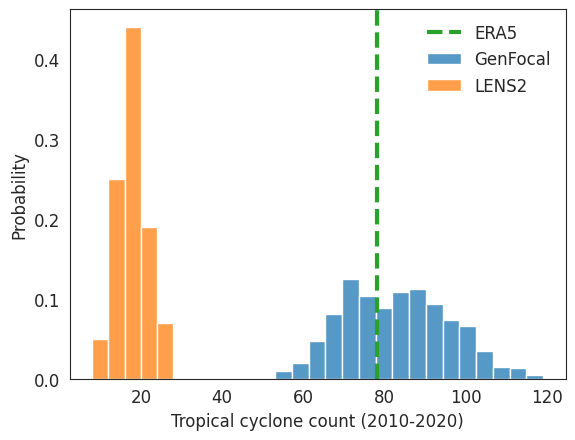

In [ ]:
# Plot count histogram
plt.figure()
plt.axvline(x=ref_count, color="C2", linestyle="--", linewidth=3, label="ERA5")
sns.histplot(genfocal_counts, stat="probability", label="GenFocal", binwidth=4)
sns.histplot(lens2_counts, stat="probability", label="LENS2", binwidth=4)
plt.xlabel("Tropical cyclone count (2010-2020)")
plt.legend(frameon=False)
plt.show()

## Distribution of TC track lengths

Another important factor in tropical cyclone analysis is the typical length they traverse from genesis to dissipation. We analyze the distribution of track lengths below.

In [ ]:
#@title Track length helper functions

def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371.0  # Radius of the Earth in kilometers

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance


def estimate_path_length(coordinates):
    if len(coordinates) < 2:
        return 0.0

    total_distance = 0.0
    for i in range(len(coordinates) - 1):
        lon1, lat1 = coordinates[i]
        lon2, lat2 = coordinates[i + 1]
        total_distance += haversine_distance(lat1, lon1, lat2, lon2)

    return total_distance


def track_length(track_df):
  lengths = []
  for track_id in track_df["track_id"].unique():
    track_rows = track_df[track_df["track_id"] == track_id]
    track_lon, track_lat = track_rows["lon"].to_numpy(), track_rows["lat"].to_numpy()
    lengths.append(estimate_path_length(np.stack([track_lon, track_lat], -1)))

  return np.asarray(lengths)

In [ ]:
#@title Compute track length

genfocal_lengths = [track_length(track) for track in tracks]
lens2_lengths = [track_length(track) for track in lens2_tracks]
ref_lengths = track_length(ref_tracks)

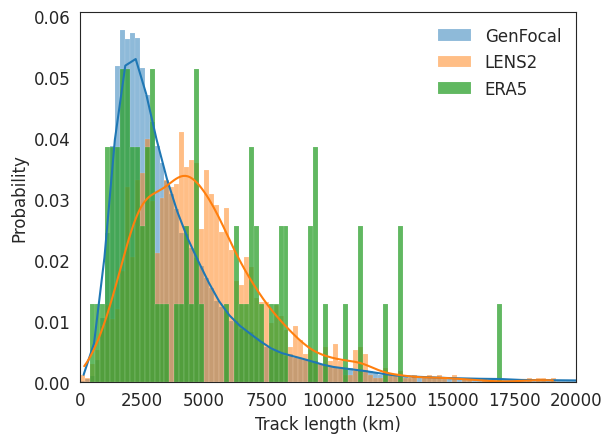

In [ ]:
#@title Track length histogram
plot_range = (0, 20000)

plt.figure()

genfocal_lengths_pooled = np.concatenate(genfocal_lengths)  # pooling all members together
counts, bin_edges = np.histogram(genfocal_lengths_pooled, bins=100, range=plot_range)

lens2_lengths_pooled = np.concatenate(lens2_lengths)  # pooling all members together
counts, bin_edges = np.histogram(lens2_lengths_pooled, bins=100, range=plot_range)

ax = sns.histplot(genfocal_lengths_pooled, bins=bin_edges, stat="probability", label="GenFocal", kde=True)
sns.histplot(lens2_lengths_pooled, bins=bin_edges, stat="probability", label="LENS2", kde=True)
sns.histplot(ref_lengths, bins=bin_edges, stat="probability", label="ERA5")
ax.set_xlim(plot_range)
plt.xlabel("Track length (km)")
plt.legend(frameon=False)
plt.show()

## Distribution in the Saffir-Simpson Hurricane Wind Scale

Here we analyze the intensity of the simulated tropical cyclones according to the Saffir-Simpson scale.

The distribution is given in terms of the TC counts, and in terms of the TC fraction for each category. After calibration, GenFocal produces tropical cyclones with an intensity distribution that follows closely that of the reference dataset. Note that even after optimally calibrating LENS2, the distribution of tropical cyclones strongly deviates from the ERA5 distribution.

In [ ]:
#@title Saffir-Simpson category functions

def ah_wind(pc):
  """Returns the pressure-derived maximum wind speed of Atkinson and Holliday.

  Args:
    pc: Pressure minimum (in Pa).

  Returns:
    Maximum wind speed, in m/s.
  """
  # From Atkinson, G. D., and Holliday C. R. , 1977: Tropical cyclone minimum s
  # ea level pressure/maximum sustained wind relationship for the western North
  # Pacific. Mon. Wea. Rev., 105 , 421–427.

  if (pc < 101000.0):
    return 3.4 * (1010.0-pc*0.01)**0.644
  else:
    return 0.0

def Saffir_Simpson(wind_speed):
  """Returns the TC category for a given wind speed according to the Saffir-Simpson scale."""
  if wind_speed <= 17:
    return "Tropical Depression"
  elif wind_speed <= 32:
    return "Tropical Storm"
  elif wind_speed <= 42:
    return "Category 1 Hurricane"
  elif wind_speed <= 49:
    return "Category 2 Hurricane"
  elif wind_speed <= 58:
    return "Category 3 Hurricane"
  elif wind_speed <= 70:
    return "Category 4 Hurricane"
  elif wind_speed > 70:
    return "Category 5 Hurricane"
  else:
    return "Unknown"

def category_calib(tracks, delta_p_calib, normalize=True):
  """Returns the TC category of given tracks after calibration.

  Calibration is performed by rescaling the sea level pressure depression used
  as threshold for TC detection, and consistently modifying the pressure-derived
  maximum sustained winds.

  Args:
    tracks: The tropical cyclone tracks.
    delta_p_calib: SLP increase above which tropical cyclones are detected,
      used to rescale consistently the pressure-derived wind speed.

  Returns:
    categories: A list of categories of tropical cyclones in terms of the
      Saffir-Simpson scale.
    cal_tracks: The tracks with calibrated pressure and wind speeds.
  """
  offset = 101000 * (1 - DELTA_P / delta_p_calib) # Pa

  cal_tracks = []
  for i in range(len(tracks)):
    cal_track = tracks[i]
    cal_track["slp_cal"] = cal_track["slp"].apply(lambda x: x * DELTA_P / delta_p_calib + offset)
    cal_track["ah_wind_cal"] = cal_track["slp_cal"].apply(ah_wind)
    cal_track["saffir_simpson_cal"] = cal_track["ah_wind_cal"].apply(Saffir_Simpson)
    cal_tracks.append(cal_track)

  categories = [
      track["saffir_simpson_cal"].value_counts(normalize=normalize).reindex(CATEGORY_ORDER, fill_value=0)
      for track in cal_tracks
  ]

  return categories, cal_tracks

In [ ]:
#@title Plotting functions

def plot_categories(ax, cat_ours, cat_lens, cat_ref, use_title=False, legend_fontsize=12, label_font_size=12, ylim=1):
  x = np.arange(len(CATEGORY_ORDER))
  bar_width = 0.2

  cat_mean = pd.concat(cat_ours, axis=1).mean(axis=1)
  cat_std = pd.concat(cat_ours, axis=1).std(axis=1)
  ax.bar(x, cat_mean, yerr=cat_std, width=bar_width, label="GenFocal")

  cat_mean_lens = pd.concat(cat_lens, axis=1).mean(axis=1)
  cat_std_lens = pd.concat(cat_lens, axis=1).std(axis=1)
  ax.bar(x - bar_width, cat_mean_lens, yerr=cat_std_lens, width=bar_width, label="LENS2")

  ax.bar(x + bar_width, cat_ref, width=bar_width, label="ERA5")
  ax.set_xticks(ticks=x, labels=CATEGORY_LABELS, rotation=45, ha="center", fontsize=label_font_size)
  ax.legend(frameon=False, fontsize=legend_fontsize)
  ax.set_xlabel("")
  ax.set_ylim([0, ylim])
  ax.set_ylabel("Fraction")
  if use_title:
    ax.set_title(f"TC categories {label}")

def plot_category_counts(
    ax, cat_ours, cat_lens, cat_ref, count_ours, count_lens, count_ref,
    use_title=False, legend_fontsize=12, label_font_size=12
):
  x = np.arange(len(CATEGORY_ORDER))
  bar_width = 0.2

  cat_ours = [cat * count for cat, count in zip(cat_ours, count_ours)]
  cat_mean = pd.concat(cat_ours, axis=1).mean(axis=1)
  cat_std = pd.concat(cat_ours, axis=1).std(axis=1)
  ax.bar(x, cat_mean, yerr=cat_std, width=bar_width, label="GenFocal")

  cat_lens = [cat * count for cat, count in zip(cat_lens, count_lens)]
  cat_mean_lens = pd.concat(cat_lens, axis=1).mean(axis=1)
  cat_std_lens = pd.concat(cat_lens, axis=1).std(axis=1)
  ax.bar(x - bar_width, cat_mean_lens, yerr=cat_std_lens, width=bar_width, label="LENS2")

  cat_ref = cat_ref * count_ref
  ax.bar(x + bar_width, cat_ref, width=bar_width, label="ERA5")
  ax.set_xticks(ticks=x, labels=CATEGORY_LABELS, rotation=45, ha="center", fontsize=label_font_size)
  ax.legend(frameon=False, fontsize=legend_fontsize)
  ax.set_xlabel("")
  ax.set_ylabel("Count $\times$")
  if use_title:
    ax.set_title(f"TC categories {label}")

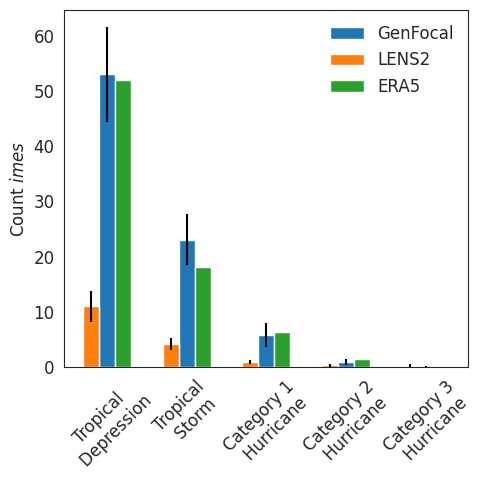

In [ ]:
#@title Plot of Saffir-Simpson distribution (counts)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ref_categories = ref_tracks["saffir_simpson"].value_counts(normalize=True).reindex(CATEGORY_ORDER, fill_value=0)
cat_ours, cal_tracks = category_calib(tracks, delta_p_calib=120)
cat_lens, lens2_cal_tracks = category_calib(lens2_tracks, delta_p_calib=20)

plot_category_counts(ax, cat_ours, cat_lens, ref_categories,
                     genfocal_counts, lens2_counts, ref_count)

plt.show()

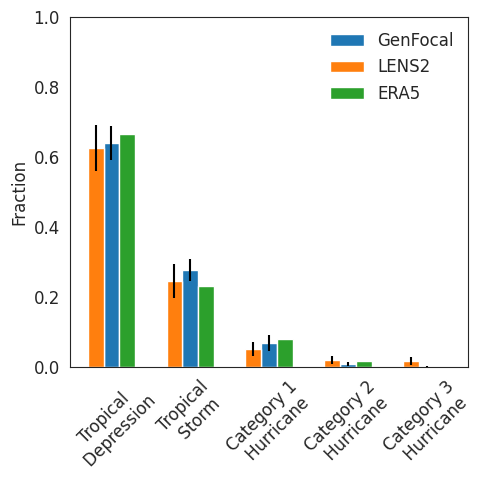

In [ ]:
#@title Plot of Saffir-Simpson distribution (normalized)
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ref_categories = ref_tracks["saffir_simpson"].value_counts(normalize=True).reindex(CATEGORY_ORDER, fill_value=0)
cat_ours, cal_tracks = category_calib(tracks, delta_p_calib=120)
cat_lens, lens2_cal_tracks = category_calib(lens2_tracks, delta_p_calib=20)

plot_categories(ax, cat_ours, cat_lens, ref_categories)

plt.show()

## Distribution of pressure-derived maximum sustained winds

The intensity distribution of the simulated tropical cyclones can also be analyzed in a continuous fashion through the distribution of pressure-derived maximum sustained winds. The distributions are plotted below, in terms of their kernel density estimates.

In [ ]:
#@title Computation of kernel density estimates (KDEs)

from scipy.stats import gaussian_kde

wind_prof_vals = np.linspace(0, 70, 140)

ref_kde = gaussian_kde(ref_tracks["ah_wind"])
ref_wind_dens = ref_kde(wind_prof_vals)

genfocal_wind_dens_calib = []
lens2_wind_dens_calib = []
for track in cal_tracks:
  kde = gaussian_kde(track["ah_wind_cal"])
  genfocal_wind_dens_calib.append(kde(wind_prof_vals))

for track in lens2_cal_tracks:
  kde = gaussian_kde(track["ah_wind_cal"])
  lens2_wind_dens_calib.append(kde(wind_prof_vals))

genfocal_wind_dens_calib = np.asarray(genfocal_wind_dens_calib)
lens2_wind_dens_calib = np.asarray(lens2_wind_dens_calib)

mean_wind_dens_calib = genfocal_wind_dens_calib.mean(axis=0)
std_wind_dens_calib = genfocal_wind_dens_calib.std(axis=0)

mean_wind_dens_lens2 = lens2_wind_dens_calib.mean(axis=0)
std_wind_dens_lens2 = lens2_wind_dens_calib.std(axis=0)

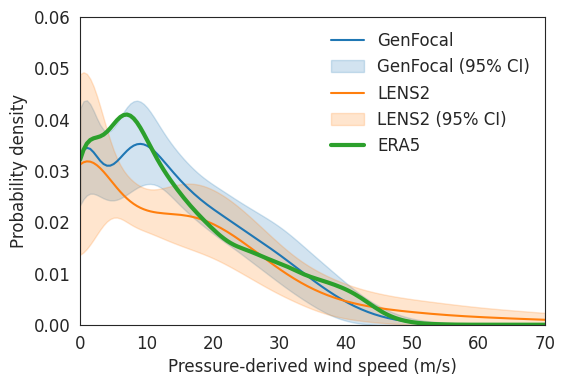

In [ ]:
#@title Plot of wind speed KDEs
plt.figure(figsize=(6, 4))

plt.plot(wind_prof_vals, mean_wind_dens_calib, color="C0", label="GenFocal")
plt.fill_between(
    wind_prof_vals, mean_wind_dens_calib - 2 * std_wind_dens_calib, mean_wind_dens_calib + 2 * std_wind_dens_calib,
    color="C0", alpha=0.2, label="GenFocal (95% CI)"
)

plt.plot(wind_prof_vals, mean_wind_dens_lens2, color="C1", label="LENS2")
plt.fill_between(
    wind_prof_vals, mean_wind_dens_lens2 - 2 * std_wind_dens_lens2, mean_wind_dens_lens2 + 2 * std_wind_dens_lens2,
    color="C1", alpha=0.2, label="LENS2 (95% CI)"
)

plt.plot(wind_prof_vals, ref_wind_dens, color="C2", label="ERA5", linewidth=3)

# plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.0, 0.5))

plt.legend(frameon=False)
plt.xlabel("Pressure-derived wind speed (m/s)")
plt.ylabel("Probability density")
plt.xlim(0, 70)
plt.ylim(0, 0.06)
plt.show()

## Cyclogenesis

Finally, we present the genesis latitude and longitude distribution for all simulated tropical cyclones.

In [ ]:
#@title Computation

GenFocal_cyclogenesis = []
LENS_cyclogenesis = []
for track in tracks:
  GenFocal_cyclogenesis.append(track.groupby('track_id').first())

GenFocal_cyclogenesis_agg = pd.concat(GenFocal_cyclogenesis)

for track in lens2_tracks:
  LENS_cyclogenesis.append(track.groupby('track_id').last())

LENS_cyclogenesis_agg = pd.concat(LENS_cyclogenesis)


# Assuming ref_tracks is your DataFrame and it has a 'track_id' column
ref_cyclogenesis = ref_tracks.groupby('track_id').first()


LENS_cyclogenesis_filtered = []
for genesis in LENS_cyclogenesis:
  LENS_cyclogenesis_filtered.append(genesis[genesis['lat'] <= 30])
LENS_cyclogenesis_agg_filtered = LENS_cyclogenesis_agg[LENS_cyclogenesis_agg['lat'] <= 30]

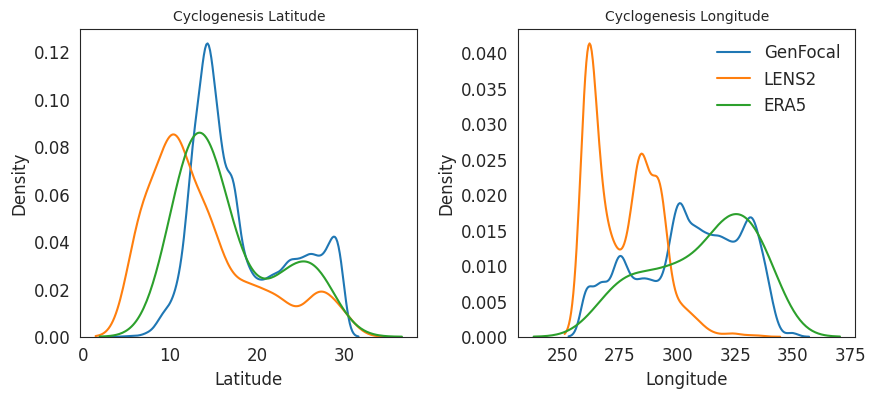

In [ ]:
#@title Plot of the distribution of cyclogenesis locations

fig = plt.figure(figsize=(10, 4), dpi=100, constrained_layout=True)
gs = mpl.gridspec.GridSpec(
    1, 2, wspace=.3, hspace=0.5,
    width_ratios=[1, 1]
)
color_sns = sns.color_palette()
hist_color = {'lens2': color_sns[1], 'genfocal': color_sns[0], 'era5': color_sns[2]}

ax0 = fig.add_subplot(gs[0,0])

sns.kdeplot(GenFocal_cyclogenesis_agg['lat'], ax=ax0, color=hist_color['genfocal'], label="GenFocal")
sns.kdeplot(LENS_cyclogenesis_agg_filtered['lat'], ax=ax0, color=hist_color['lens2'], label="LENS")
sns.kdeplot(ref_cyclogenesis['lat'], ax=ax0, color=hist_color['era5'], label="ERA5")

ax0.set_xlabel('Latitude')
ax0.set_ylabel('Density')
ax0.set_title('Cyclogenesis Latitude', fontsize=10)



ax8 = fig.add_subplot(gs[0,1])
sns.kdeplot(GenFocal_cyclogenesis_agg['lon'], ax=ax8, color=hist_color['genfocal'], label="GenFocal")
sns.kdeplot(LENS_cyclogenesis_agg_filtered['lon'], ax=ax8, color=hist_color['lens2'], label="LENS2")
sns.kdeplot(ref_cyclogenesis['lon'], ax=ax8, color=hist_color['era5'], label="ERA5")
ax8.legend(frameon=False)
ax8.set_xlabel('Longitude')
ax8.set_ylabel('Density')
ax8.set_title('Cyclogenesis Longitude', fontsize=10)

plt.show()